<IPython.core.display.Javascript object>


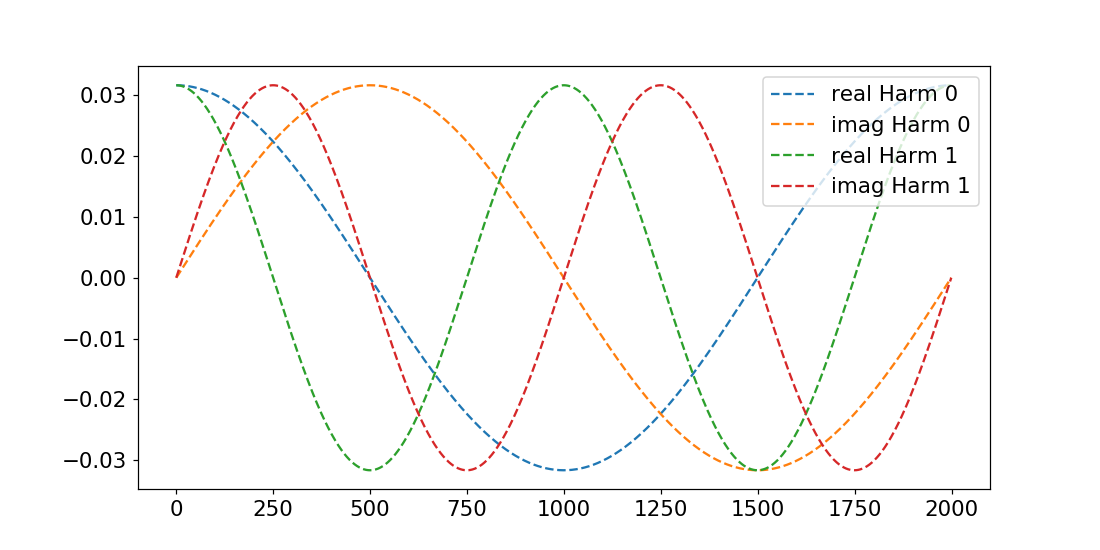

In [34]:
%matplotlib notebook
import numpy as np
from scipy import sparse, linalg
import matplotlib.pyplot as plt
from scipy.misc import derivative
#from scipy import optimize
import sys
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from amfe.frequency_module.frequency import cos_bases_for_MHBM, create_Z_matrix, linear_harmonic_force, hbm_complex_bases
from amfe.optimize import optimize
from ipywidgets import interact
from matplotlib.animation import FuncAnimation, writers
import matplotlib.animation as animation


plt.rcParams.update({'font.size': 14})


#B = cos_bases_for_MHBM(1,number_of_harm=1,static=False)
nH = 2
n_points = 2000
q = hbm_complex_bases(1,number_of_harm=nH,n_points=n_points,static=False,normalized=False)

fig = plt.figure(figsize=(10,5))
for i in range(q.shape[1]):
#for i in range(2):
    plt.plot(q[:,i].real,'--',label='real Harm ' + str(i))
    plt.plot(q[:,i].imag,'--',label='imag Harm ' + str(i))
 
plt.legend(loc='upper right')
plt.show()

<IPython.core.display.Javascript object>


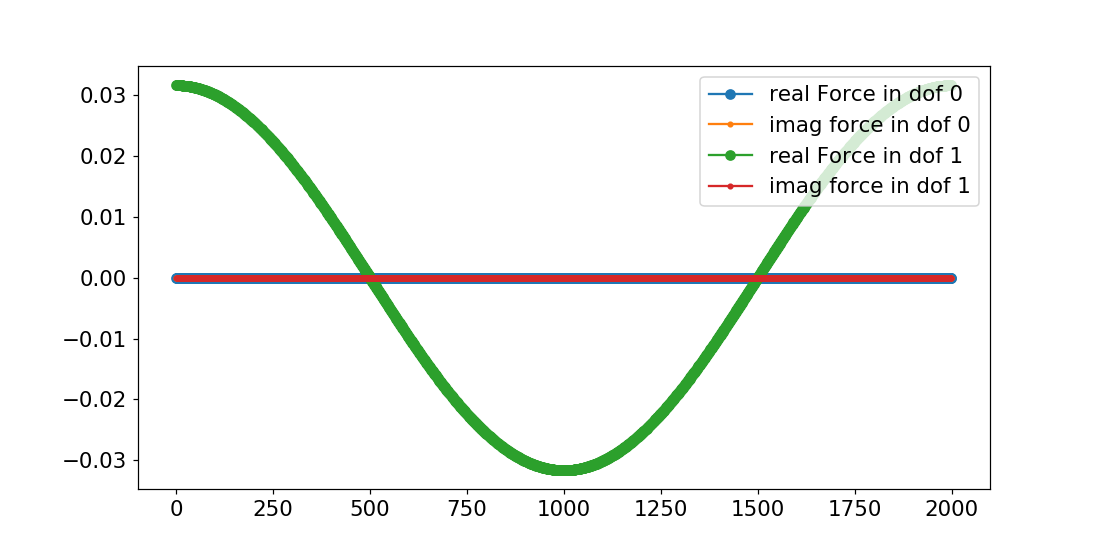

In [35]:
amplitude_dof_2 = 1.0
Bc = np.array([0,1]) # dof section ma
P = np.array([0.0,amplitude_dof_2], dtype = np.complex)
beta = 2.0
m1 = 1.0
m2 = m1
k1 = 1.0
k2 = k1
c1 = 0.05
c2 = c1

K = np.array([[k1+k2, -k2],
              [-k2,k2]])

M = np.array([[m1,0.0],
              [0.0,m2]])

C = np.array([[c1+c2,-c2],
              [-c2,c2]])

n_dofs = K.shape[0] 
I = np.eye(n_dofs)
I_harm = np.eye(nH)
#Q = np.kron(q ,[1]*nH)
Q = np.kron(I,q[:,0])
for i in range(1,nH):
    Q = np.concatenate([Q,np.kron(I,q[:,i])])
Q = Q.T

P_aug = list(0*P)*nH
P_aug[0:n_dofs] = list(P)
P_aug = np.array(P_aug)
Bc_aug = sparse.kron(I_harm,Bc)
#fl = linear_harmonic_force(P, f0 = 1, n_points=50, cos=True)
fl = Q.dot(P_aug).real
#fl = np.kron(I.toarray().dot(P),q).real

fig = plt.figure(figsize=(10,5))
for i in range(int(fl.shape[0]/n_points)):
    plt.plot(fl[i*n_points:(i+1)*n_points].real,'o-',label='real Force in dof ' + str(i))
    plt.plot(fl[i*n_points:(i+1)*n_points].imag,'.-',label='imag force in dof ' + str(i))
 
plt.legend(loc='upper right')
plt.show()

<IPython.core.display.Javascript object>


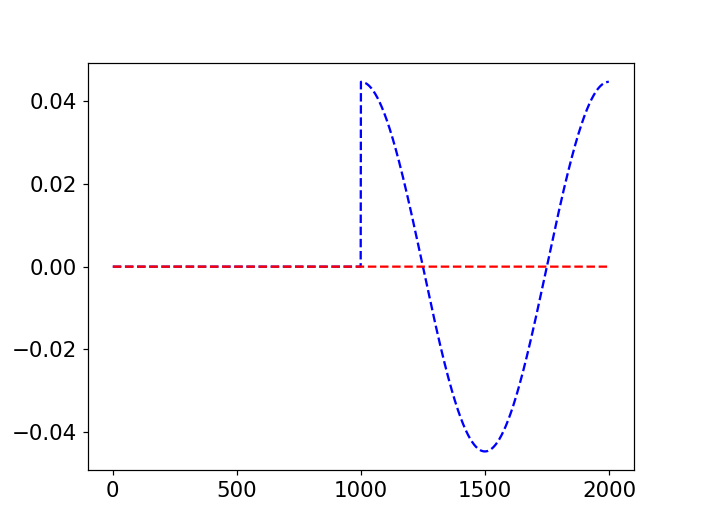

In [29]:
plt.figure()
plt.plot(fl.real,'b--')
plt.plot(fl.imag,'r--')

(2000, 4)


<IPython.core.display.Javascript object>


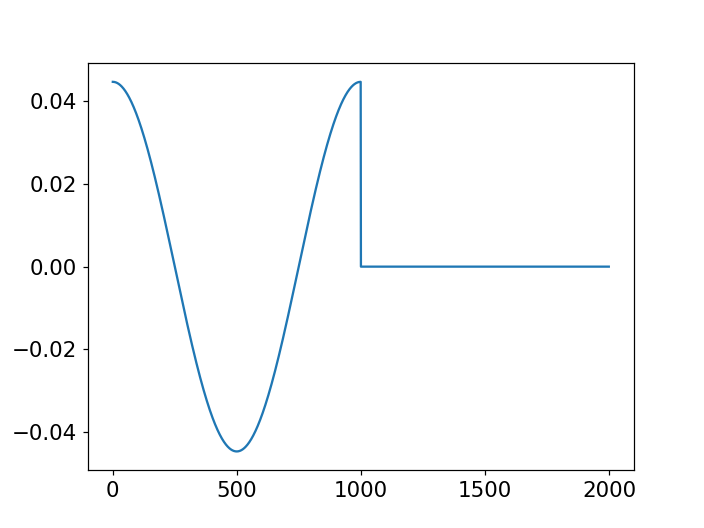

In [30]:
print(Q.shape)

plt.figure()
plt.plot(Q[:,0].real)

In [31]:
fl_ = Q.conj().T.dot(fl) # force in frequency domain
fl_

array([0.   +0.00000000e+00j, 1.001-5.23394364e-17j,
       0.   +0.00000000e+00j, 0.002-2.67992754e-17j])

In [36]:
fl_ = Q.conj().T.dot(fl) # force in frequency domain
fl_ = Bc_aug.T.dot(Bc_aug.dot(fl_))

fnl = lambda u : beta*(u**3)
fnl_ = lambda u_ : Bc_aug.T.dot(Bc_aug.dot(Q.conj().T.dot(fnl(Q.dot(u_).real)) - fl_))
Z = lambda w :create_Z_matrix(K,C,M,f0= w/(2.0*np.pi),nH=nH, static=False)
#Z = lambda w: np.array([-(w)**2*M + 1J*(w)*C + K]) 
R = lambda u_, w : Z(w).dot(u_) + fnl_(u_)


In [37]:
%%time
correction_method='matcont'
#correction_method='fixed_parameter'
#correction_method='moore_penrose'
#correction_method='optimize_matcont'

#correction_method='fixed_direction'
x0 = np.array([0.0]*n_dofs*nH,dtype=np.complex)
y_d, p_d, info_dict = optimize.continuation(R,x0=x0,p_range=(0.01,3.0), p0=0.1, max_int=2000, correction_method=correction_method,
                                            max_dp=0.1,step=0.1, max_int_corr=50, tol=1.0E-10)
y_d = y_d*(P[1]/fl_.real[1])

c:\amfe\amfe\optimize\optimize.py:607: LinAlgWarning: Diagonal number 8 is exactly zero. Singular matrix.
  lu_factor = linalg.lu_factor(Gy_eval)
c:\amfe\amfe\optimize\optimize.py:51: RuntimeWarning: invalid value encountered in multiply
  x0 = x0_real + 1J*x0_imag
C:\Users\ge72tih\AppData\Local\Continuum\anaconda3\envs\ndcsi\lib\site-packages\numdifftools\step_generators.py:102: RuntimeWarning: invalid value encountered in greater
  if (np.abs(step) > 0).all():


IndexError: list index out of range

In [33]:
%%time
#correction_method='matcont'
#correction_method='fixed_parameter'
correction_method='moore_penrose'
#correction_method='optimize_matcont'

#correction_method='fixed_direction'
x0 = np.array([0.0]*n_dofs*nH,dtype=np.complex)
y_d, p_d, info_dict = optimize.continuation(R,x0=x0,p_range=(0.01,3.0), p0=0.1, max_int=2000, correction_method=correction_method,
                                            max_dp=0.1,step=0.1, max_int_corr=50, tol=1.0E-10)
y_d = y_d*(P[1]/fl_.real[1])

Using iterative solver = -86213746486331916288.000000


C:\Users\ge72tih\AppData\Local\Continuum\anaconda3\envs\ndcsi\lib\site-packages\numdifftools\step_generators.py:102: RuntimeWarning: invalid value encountered in greater
  if (np.abs(step) > 0).all():


IndexError: list index out of range

In [ ]:
%%time
#correction_method='matcont'
#correction_method='fixed_parameter'
#correction_method='moore_penrose'
correction_method='optimize_matcont'

#correction_method='fixed_direction'
x0 = np.array([0.0]*n_dofs*nH,dtype=np.complex)
y_d, p_d, info_dict = optimize.continuation(R,x0=x0,p_range=(0.01,3.0), p0=0.1, max_int=2000, correction_method=correction_method,
                                            max_dp=0.1,step=0.1, max_int_corr=50, tol=1.0E-10)
y_d = y_d*(P[1]/fl_.real[1])

In [ ]:
%%time
#correction_method='matcont'
#correction_method='fixed_parameter'
#correction_method='moore_penrose'
correction_method='fixed_direction'

#correction_method='fixed_direction'
x0 = np.array([0.0]*n_dofs*nH,dtype=np.complex)
y_d, p_d, info_dict = optimize.continuation(R,x0=x0,p_range=(0.01,3.0), p0=0.1, max_int=2000, correction_method=correction_method,
                                            max_dp=0.1,step=0.1, max_int_corr=50, tol=1.0E-10)
y_d = y_d*(P[1]/fl_.real[1])

In [ ]:
dof_id = 0

fig, ax1 = plt.subplots(1)
max_x = np.abs(p_d).max()
min_x = np.abs(p_d).min()
max_y = np.abs(y_d[dof_id]).max()
min_y = np.abs(y_d[dof_id]).min()

factor = 0.1
lim = lambda x, factor  : x + np.sign(x)*factor*x

ax1.set_xlim([lim(min_x,-factor)   ,lim(max_x,factor)])
ax1.set_ylim([lim(min_y,-factor)   ,lim(max_y,factor)])


def update(i):
    ax1.clear()
    ax1.plot(p_d[i],np.abs(y_d[dof_id][i]),'ro',markerfacecolor='y')
    ax1.plot(p_d[:i],np.abs(y_d[dof_id][:i]),'k.')
    ax1.set_xlim([lim(min_x,-factor)   ,lim(max_x,factor)])
    ax1.set_ylim([lim(min_y,-factor)   ,lim(max_y,factor)])
    ax1.set_xlabel('Frequency [rad/s]', fontsize=12)
    ax1.set_ylabel('Normalized Amplitude', fontsize=12)
    #ax1.plot(p_d[i],y_d[0][i],'bo')
    ax1.set_title('2 dofs Duffing Oscillator with 5 Harmonics and 1000 time samples', fontsize=12)
ani = FuncAnimation(fig, update, frames=np.arange(0, len(p_d) ,3 ), blit=True, interval=1)   

save = False
if save:
    Writer = animation.writers['imagemagick']
    writer = Writer(fps=30, metadata=dict(artist='Guilherme Jenovencio'), bitrate=1800)
    ani.save('2dof_duffing_ocsillator_v4.gif', dpi=200, writer=writer)

In [ ]:
plt.figure()
plt.plot(p_d.real)
plt.plot(p_d.imag)

In [ ]:
%%time
p = np.linspace(0.01,4,500)
Ru = lambda f : lambda u_ : R(u_,f)
#x0 = np.array([0],dtype=np.complex)
x0 = np.array([0]*n_dofs*nH,dtype=np.complex)
x_list = []
f_list = []
for f in p:
    opt_obj = optimize.root(Ru(f),x0=x0,tol=1.0E-12)
    x_opt = opt_obj.x
    #x0 = x_opt
    if opt_obj.success:
        x_list.append(x_opt)
        f_list.append(f)
    

In [ ]:
plt.figure()
plt.plot(f_list, np.abs(x_list),'o')

In [ ]:
val, vec = linalg.eig(K,M)

In [ ]:
np.sqrt(1/val)

In [ ]:
opt_obj = optimize.root(Ru(0.25),x0=x0,tol=1.0E-12)

In [ ]:
opt_obj

In [ ]:
fnl(opt_obj.x)